In [ ]:
# pip install pandas

In [ ]:
# pip install matplotlib

In [ ]:
# pip install gensim

In [ ]:
# pip install openpyxl

In [1]:
import random
import numpy as np
import pandas as pd
import time
import re
import datetime
import os
import matplotlib.pyplot as plt
import gensim
# import spacy

In [2]:
# pip install bertopic

In [3]:
# conda install -c conda-forge ipywidgets

In [4]:
# from ipywidgets import FloatProgress

In [5]:
from bertopic import BERTopic

## Read data

In [6]:
# conda install -c anaconda openpyxl 

In [7]:
df0 = pd.read_excel('data/Jul21_3379_articles.xlsx',index_col=0)
df0 = df0.reset_index()
df0 = df0.drop(columns=['index'])
df0.head()

,newsOutlet,dateSeen,url,title,language,sourceCountry,text,category,textCharCt
0,apnews.com,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,BRUSSELS (AP) — The European Union is consider...,western,3318
1,apnews.com,2021-10-12 07:00:00,https://apnews.com/cdfd9b277f6bade5697e0427429...,Blinken reaffirms US support for Ukraine amid ...,English,United States,"KYIV, Ukraine (AP) — U.S. Secretary of State A...",western,6032
2,apnews.com,2021-10-11 07:00:00,https://apnews.com/90b50e622cefcbaeba96cb5e716...,"EU , Ukraine to discuss military training and ...",English,United States,BRUSSELS (AP) — The European Union is consider...,western,3318
3,apnews.com,2021-10-06 07:00:00,https://apnews.com/0b689a7baaac58603e4d7453aa5...,Ukraine Holocaust center names Nazi Babi Yar k...,English,United States,"KYIV, Ukraine (AP) — The presidents of Ukraine...",western,3646
4,apnews.com,2021-10-13 07:00:00,https://apnews.com/89d2455274aad5fe166445a5f82...,Ukraine separatist areas overwhelmed by soarin...,English,United States,"KYIV, Ukraine (AP) — The Russia-backed separat...",western,2184


In [8]:
# Moscow times
mtdf = pd.read_excel('data/themoscowtimes.com_07-21-2022.xlsx',index_col=0)
mtdf = mtdf.drop_duplicates(subset=['text'])
mtdf = mtdf[mtdf['text'].apply(lambda t : t.lower().count('ukrain') >= 2)]
mtdf['category'] = 'moscowtimes'
mtdf.head()

,newsOutlet,dateSeen,url,title,language,sourceCountry,text,category
0,themoscowtimes.com,1633071600,https://www.themoscowtimes.com/2021/10/01/ukra...,Ukraine Calls for Russia Sanctions Over Hungar...,English,Russia,Ukraine said Friday it wants Germany and the U...,moscowtimes
1,themoscowtimes.com,1634194800,https://www.themoscowtimes.com/2021/10/14/form...,Former Head of Chernobyl Nuclear Plant Dies - ...,English,Russia,The director of the Chernobyl nuclear plant wh...,moscowtimes
2,themoscowtimes.com,1633935600,https://www.themoscowtimes.com/2021/10/11/russ...,Russia Shouldnt Negotiate With Vassal Ukrain...,English,Russia,Russia cannot negotiate with the “vassal” lead...,moscowtimes
3,themoscowtimes.com,1634022000,https://www.themoscowtimes.com/2021/10/12/russ...,"Russia , France , Germany May Meet on Ukraine ...",English,Russia,"Russia, France and Germany said Monday that th...",moscowtimes
4,themoscowtimes.com,1634281200,https://www.themoscowtimes.com/2021/04/12/2-uk...,2 Ukrainian Soldiers Killed in War - Torn Sepa...,English,Russia,Two Ukrainian soldiers have been killed in cla...,moscowtimes


In [9]:
df = pd.concat([df0, mtdf],axis=0)
df = df.drop_duplicates(['text'])
df = df.reset_index()
del df['index']
len(df)

3487

In [10]:
df.tail()

,newsOutlet,dateSeen,url,title,language,sourceCountry,text,category,textCharCt
3482,themoscowtimes.com,1642060800,https://www.themoscowtimes.com/2022/01/13/sanc...,"Sanctions on Putin Would be Step Too Far , Kre...",English,Russia,The United States’ plans to levy sanctions aga...,moscowtimes,NaN
3483,themoscowtimes.com,1641801600,https://www.themoscowtimes.com/2022/01/10/news...,News From Russia : What You Missed Over the We...,English,Russia,Security talks A top Russian official said he ...,moscowtimes,NaN
3484,themoscowtimes.com,1642147200,https://www.themoscowtimes.com/2022/01/14/russ...,"Russian Diplomat Praises Rappers Ye , Oxxxymir...",English,Russia,Will hip-hop actually save the world? A senior...,moscowtimes,NaN
3485,themoscowtimes.com,1641801600,https://www.themoscowtimes.com/2022/01/10/kaza...,Kazakhstan Largest City Back Online After Clas...,English,Russia,Kazakhstan's largest city was back online and ...,moscowtimes,NaN
3486,themoscowtimes.com,1641456000,https://www.themoscowtimes.com/2022/01/06/russ...,Russia Involvement in Kazakhstan Crisis Could ...,English,Russia,Russia’s deployment of troops as part of a mil...,moscowtimes,NaN


## Pre-process documents

In [11]:
import nltk
from nltk.tokenize import sent_tokenize

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/paigelee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
# process texts
def tm_tokenize(txt):
    word_corrections = [
    ('said',''),
    ('Reuters',''),
    ('REUTERS',''),
    ('Thomson',''),
    ('AP', ''),
    ('Sputnik',''),
    ('TASS',''),
    ('BBC',''),
    ('Kiev ','Kyiv '),
    ('Lugansk','Luhansk'),
    ('Donbas','Donbass'),
    ('U.S.','US'),
    ('United States','US'),
    (''' We'd love to get your feedback at radio@sputniknews.com''',''),
    ('radio@sputniknews.com',''),
    ('Aleksandr', 'Alexander'),
    ('Zelensky','Zelenskyy'),
    ('Zelenskiy','Zelenskyy'),
    ]
    takeoutif = [
        'This story has been corrected to show',
        'contributed to this report',
        'All rights reserved',
        'not responsible for the material quoted in these press',
        'Follow all AP stories',
        'https',
        'dedicated page',
        'Follow AP’s coverage',
        '©',
        'This video can not be played',
        '© 2022 Reuters.'
        'contributed reporting',
        'Please include your name, age and location with any submission.',
        'See here for',
        'contributed.',
        'reported from',
        'reaching billions of people worldwide every day',
        'quotes delayed a minimum',
        'contributed to this story.',
        'pic.twitter.com',
        'Screen for heightened risk individual and entities globally to help uncover hidden risks in business relationships and human networks.',
        'Browse an unrivalled portfolio of',
        'Access unmatched financial',
        'Reuters',
        'Build the strongest argument relying on',
        'The most comprehensive solution to manage all',
        'Access unmatched financial data',
        'The industry leader for online information for tax'
        ]
    for a, b in word_corrections:
        txt = txt.replace(a, b)
    for string in takeoutif:
        if string in txt:
            return None
    if not txt[0].isalpha() and txt[0] not in ['"',"'",'“']:
        return None
    if len(txt) <= 50:
        return None
    return txt

In [14]:
docs = []
texts = []

article2sents = dict()

listBySent = []
records = df.to_dict('records')
totalSents = 0
validSents = 0
for i, rec in enumerate(records):
    if i % 500 == 0:
        print(f'{i}/{len(records)} articles processed')
    rec_text = rec['text']
    # if rec_text.lower().count('ukrain') < 2:
        # continue
    if isinstance(rec_text, str):
        sents = sent_tokenize(rec_text)
        validSentsinDoc = []
        sentIdx = 0
    
        for text in sents:
            sentRec = dict()
            sentRec['index'] = i
            sentRec['newsOutlet'] = rec['newsOutlet']
            sentRec['category'] = rec['category']
            sentRec['dateSeen'] = rec['dateSeen']
            sentRec['url'] = rec['url']
            sentRec['title'] = rec['title']
            sentRec['language'] = rec['language']
            sentRec['sourceCountry'] = rec['sourceCountry']
            
            cleaned_text = tm_tokenize(text)
            totalSents += 1
            if cleaned_text == None:
                continue
            else:
                docs.append(cleaned_text)
                texts.append(text)
                sentRec['sentText'] = text
                sentRec['sentIndexInText'] = sentIdx
                listBySent.append(sentRec)
                validSentsinDoc.append({
                    'sentText' : text,
                    'topic' : -2
                })
                validSents += 1
                sentIdx += 1
                
        article2sents[i] = validSentsinDoc
        
print(f'{validSents}/{totalSents} sentences valid.\n')
print(len(docs),'docs processed successfully!')

0/3487 articles processed
500/3487 articles processed
1000/3487 articles processed
1500/3487 articles processed
2000/3487 articles processed
2500/3487 articles processed
3000/3487 articles processed
56609/67808 sentences valid.

56609 docs processed successfully!


## Function for model coherence

In [15]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [16]:
# COHERENCE VALUES

import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

def get_coherence(topic_model, topics, probs):

    # Preprocess Documents
    documents = pd.DataFrame({"Document": docs,
                              "ID": range(len(docs)),
                              "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)
    print('cleaned docs')

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()
    print('vectorizer/analyser')
    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                   for topic in range(len(set(topics))-1)]
    print('extract features for evaluation')
    # Evaluate
    coherence_model = CoherenceModel(topics=topic_words, 
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v',)
    
    coherence = coherence_model.get_coherence()
    print('coherence calculation complete:\n')
    print('coherence:', coherence)
    return coherence

## Initialize BERT model

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

In [23]:
# best so far: 

### Run model

In [25]:
from sentence_transformers import SentenceTransformer

In [28]:
# %%time
# sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
# embeddings = sentence_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/1770 [00:00<?, ?it/s]

CPU times: user 42min 44s, sys: 1min 9s, total: 43min 54s
Wall time: 1h 25min 29s


In [34]:
%%time

topic_model = BERTopic(language="english",vectorizer_model=vectorizer_model,
                       verbose=True,calculate_probabilities=True,nr_topics=15,diversity=.8)

topics, probs = topic_model.fit_transform(docs, embeddings)

2022-08-03 15:48:30,101 - BERTopic - Reduced dimensionality
2022-08-03 16:12:15,642 - BERTopic - Clustered reduced embeddings
2022-08-03 16:12:43,288 - BERTopic - Reduced number of topics from 610 to 16


CPU times: user 26min 39s, sys: 33.2 s, total: 27min 12s
Wall time: 25min 12s


In [36]:
topic_model.get_params()

{'calculate_probabilities': True,
 'diversity': 0.8,
 'embedding_model': None,
 'hdbscan_model': HDBSCAN(min_cluster_size=10, prediction_data=True),
 'language': 'english',
 'low_memory': False,
 'min_topic_size': 10,
 'n_gram_range': (1, 1),
 'nr_topics': 15,
 'seed_topic_list': None,
 'top_n_words': 10,
 'umap_model': UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.0, n_components=5, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 'vectorizer_model': CountVectorizer(ngram_range=(1, 2), stop_words='english'),
 'verbose': True}

In [21]:
# best .475 (40 topics, .5 diversity)
# 50 topics, .75 diversity
#40,.75 -> .376
# 50, .75 -> .416

In [39]:
%%time
original_coh = get_coherence(topic_model, topics, probs)

cleaned docs
vectorizer/analyser
extract features for evaluation
coherence calculation complete:

coherence: 0.5883751580677086
CPU times: user 7.13 s, sys: 2.57 s, total: 9.7 s
Wall time: 44.2 s


In [37]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,43337,-1_ukraine_russia_russian_nato
1,0,1576,0_sanctions_russia_russian_sanctions russia
2,1,1267,1_russia_putin_russian_president
3,2,1231,2_think_war_dont_added
4,3,1162,3_ukraine_ukrainian_ukraines_russia
5,4,961,4_zelenskyy_president_volodymyr_ukrainian pres...
6,5,950,5_nato_ukraine_alliance_membership
7,6,773,6_nord_nord stream_stream_pipeline
8,7,745,7_biden_putin_president_joe
9,8,738,8_blinken_antony_antony blinken_secretary state


### Save model

In [208]:
# %%time
# topic_model.save("100topics_diversity-8_docs_BERT_sentence_model_7-21")

In [209]:
# topic_model_div_8 = BERTopic.load('100topics_diversity-8_docs_BERT_sentence_model_7-21')

### Print topics and keywords

In [60]:
# estimates for top
topicEstimates = []
topicDocCts = dict()
for i, doc in enumerate(docs):
    topicNum = np.argmax(probs[i,:])
    topicDocCts.setdefault(topicNum, 0)
    topicDocCts[topicNum] += 1

id2keywords = dict()
for i in range(len(topic_model.get_topic_info())-1):
    keys = ' '.join([key for key, prob in topic_model.get_topic(i)])
    id2keywords[i] = keys
    print(i, topic_model.get_topic_freq(i), topicDocCts[i],keys)

0 1576 1880 sanctions russia russian sanctions russia financial ukraine banks economic new swift
1 1267 830 russia putin russian president moscow russias security dialogue vladimir added
2 1266 38708 donbasss donetsk luhansk peoples republics lpr ukrainian dpr donetsk luhansk ukraine
3 1231 815 think war dont added diplomatic situation diplomacy negotiations want time
4 1162 221 ukraine ukrainian ukraines russia situation sovereignty support integrity russian territorial integrity
5 961 1478 zelenskyy president volodymyr ukrainian president zelenskyyy president volodymyr ukrainian volodymyr zelenskyy poroshenko vladimir zelenskyy
6 950 2585 nato ukraine alliance membership join eastward russia expansion military member
7 773 2807 nord nord stream stream pipeline gas germany gas pipeline project german russia
8 745 2153 biden putin president joe joe biden president joe vladimir putin vladimir ukraine video
9 738 729 blinken antony antony blinken secretary state state antony state secret

In [91]:
docs[51432]

'On Friday, the leaders of the Luhansk and Donetsk People’s Republics announced the evacuation of the republics’ inhabitants to Russia, citing the increasing threat of hostilities.'

In [93]:
listprobs = list(probs[:,12])
highis = []
for i, prob in enumerate(listprobs):
    if prob>.5 and prob <.9999:
        highis.append(i)
highis

[38696, 39750, 47414]

In [94]:
docs[38696]

'In recent months, Western countries have accused Russia of a troop buildup near the border with Ukraine and of planning to attack the neighbouring country.'

#### Outliers with different prob threshold

In [53]:
%%time
probability_threshold = .02
new_topics = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in probs]

print(new_topics.count(-1), 'outliers with threshold of', probability_threshold)
print('this is', new_topics.count(-1)/58336)

19550 outliers with threshold of 0.02
this is 0.33512753702687875
CPU times: user 164 ms, sys: 46.3 ms, total: 210 ms
Wall time: 432 ms


## Topic evaluation

### Topic Coherence

In [206]:
%%time
original_coh = get_coherence(topic_model, topics, probs)

cleaned docs
vectorizer/analyser


TypeError: 'bool' object is not iterable

### Inter-cluster similarity

In [42]:
%%time
from sklearn.metrics.pairwise import cosine_similarity

probability_threshold = .02
new_topics = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in probs]

print(new_topics.count(-1), 'outliers with threshold of', probability_threshold)

topicVectorDict = dict()
for i, topic in enumerate(new_topics):
    topicVectorDict.setdefault(topic, [])
    topicVectorDict[topic].append(probs[i])

# for i in topicVectorDict:
    # print(len(topicVectorDict[i]))
print('now calculating cosine similarities')
clusterAvgs = []
for topicIdx in topicVectorDict:
    similarities = cosine_similarity(topicVectorDict[topicIdx])
    simList = []
    for i in range(similarities.shape[0]):
        simList.append(np.average(similarities[i,i:]))
    interclusteravg = np.average(simList)
    clusterAvgs.append(interclusteravg)
print('intercluster average is', np.average(clusterAvgs))

24812 outliers with threshold of 0.02
now calculating cosine similarities
intercluster average is 0.8874293355095918
CPU times: user 9.91 s, sys: 9.46 s, total: 19.4 s
Wall time: 26.9 s


## Article topic probabilities

### Add document probability to original dataframe

In [44]:
# create sentence df
originalSentDf = pd.DataFrame.from_records(listBySent)
originalSentDf.head()

,index,newsOutlet,category,dateSeen,url,title,language,sourceCountry,sentText,sentIndexInText
0,0,apnews.com,western,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,BRUSSELS (AP) — The European Union is consider...,0
1,0,apnews.com,western,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,Acting on a request from Ukraine for help with...,1
2,0,apnews.com,western,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,The topic will be discussed during a summit Tu...,2
3,0,apnews.com,western,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,The results of the mission have yet to be anal...,3
4,0,apnews.com,western,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,One official said the EU’s political and secur...,4


#### Add to sentence dataframe

In [45]:
%%time
probability_threshold = .02
new_topic_recs = [{'sentTopicID' : np.argmax(prob)} if max(prob) > probability_threshold else {'sentTopicID' : -1} for prob in probs]
sentTopicDf = pd.DataFrame.from_records(new_topic_recs)
fullSentTopicDf = pd.concat([originalSentDf, sentTopicDf],axis=1)
fullSentTopicDf.to_excel('data/topic_model_data/fullSentDataFrame_8-3.xlsx')
fullSentTopicDf.sample(5)

CPU times: user 9.1 s, sys: 1.74 s, total: 10.8 s
Wall time: 21.9 s


,index,newsOutlet,category,dateSeen,url,title,language,sourceCountry,sentText,sentIndexInText,sentTopicID
14011,592,reuters.com,western,2021-11-22 08:00:00,https://www.reuters.com/world/kremlin-says-it-...,Kremlin says it is alarmed by U . S .- backed ...,English,United States,"""This is whipping up tension and is another at...",5,12
13638,571,reuters.com,western,2021-11-03 07:00:00,https://www.reuters.com/business/cop/lira-batt...,Lira battles inflation as EM stocks slip ahead...,English,United States,Relations between the two countries have been ...,16,14
9109,359,apnews.com,western,2022-02-14 08:00:00,https://apnews.com/press-release/business-wire...,EL AL Israel Airlines to Assist US Citizens Le...,English,United States,EL AL also provides the most air service betwe...,3,-1
34715,1400,sputniknews.com,russian,2021-12-07 08:00:00,https://sputniknews.com/20211207/presidents-bi...,Presidents Biden and Putin to Meet Tuesday ; H...,English,Russia,"Also, US Secretary of State Antony Blinken is ...",9,-1
42178,1932,tass.com,russian,2022-01-07 08:00:00,https://tass.com/world/1384807,Fugitive banker calls himself leader of protes...,English,NaN,"According to Ablyazov, the protesters in Almat...",1,-1


#### Add to article majority dataframe

In [38]:
# copy sentence df in case things go wrong
# sentDf = originalSentDf.copy(deep=True)
articleDf = df.copy(deep=True)
articleDf = articleDf.reset_index()
del articleDf['index']

### Write topic keywords

In [47]:
# get topic keywords based on ID number
topicID2keys = dict()
for idx in range(len(topic_model.get_topic_info())-1):
    keys = ' '.join([key for key, prob in topic_model.get_topic(idx)])
    topicID2keys[idx] = keys

In [48]:
topicRecs = []
for i in topicID2keys:
    topicRecs.append({
        'TopicID' : i,
        'Topic Keywords' : topicID2keys[i]
    })
topicKeyDf = pd.DataFrame.from_records(topicRecs)
topicKeyDf.to_excel('data/topic_model_data/topic_keywords_8-4.xlsx')
topicKeyDf.head()

,TopicID,Topic Keywords
0,0,sanctions russia russian sanctions russia fina...
1,1,russia putin russian president moscow russias ...
2,2,think war dont added diplomatic situation dipl...
3,3,ukraine ukrainian ukraines russia situation so...
4,4,zelenskyy president volodymyr ukrainian presid...


In [56]:
topicKeyDf

,TopicID,Topic Keywords
0,0,sanctions russia russian sanctions russia fina...
1,1,russia putin russian president moscow russias ...
2,2,think war dont added diplomatic situation dipl...
3,3,ukraine ukrainian ukraines russia situation so...
4,4,zelenskyy president volodymyr ukrainian presid...
5,5,nato ukraine alliance membership join eastward...
6,6,nord nord stream stream pipeline gas germany g...
7,7,biden putin president joe joe biden president ...
8,8,blinken antony antony blinken secretary state ...
9,9,lavrov foreign truss foreign minister minister...


#### View # of outliers

In [41]:
# set probability threshold and add sentences according to their max prob
probability_threshold = .02
new_topics = [np.argmax(prob) if max(prob) > probability_threshold else -1 for prob in probs]

print(new_topics.count(-1), 'outliers with threshold of', probability_threshold,'\n')

16242 outliers with threshold of 0.02 



In [40]:
# set probability threshold and add sentences according to their max prob
probability_threshold = .02
new_topics = [np.argmax(prob) if max(prob) > probability_threshold else -1 for prob in probs]

print(new_topics.count(-1), 'outliers with threshold of', probability_threshold,'\n')

# topicID -> list of indices (the indices correspond to indices of sents in listBySent which are in that topic)
topicVectorDict = dict()
for i, topicID in enumerate(new_topics):
    topicVectorDict.setdefault(topicID, [])
    topicVectorDict[topicID].append(i)

# for each specific topicID
for topicID in topicVectorDict:
    # for each sent in topic group
    for sentIdx in topicVectorDict[topicID]:
        articleIdx = listBySent[sentIdx]['index']
        articleSentIdx = listBySent[sentIdx]['sentIndexInText']
        # set topicID in article list
        article2sents[articleIdx][articleSentIdx]['topic'] = topicID
    
print('populated article2sents with topicIDs')

print('collecting article topic records')
articleTopicRecords = []

# get max topic per article
for articleIdx in article2sents.keys():
    articleTopicRec = dict()
    articleTopicRec['majorityTopic'] = -2
    topicIDcts = dict()
    topicIDcts.setdefault(-1,0)
    for topicID in topicID2keys:
        topicIDcts.setdefault(topicID,0)
    for sent in article2sents[articleIdx]:
        topicID = sent['topic']
        topicIDcts[topicID] += 1
    # set topic counts in rows in article df 
    recSentCt = 0
    for topicID in topicIDcts:
        articleTopicRec.setdefault(f'topic_{topicID}', 0)
        articleTopicRec[f'topic_{topicID}'] = str(topicIDcts[topicID])
        recSentCt += topicIDcts[topicID]
    # set majority topic label
    articleTopicRec['majorityTopic'] = str(max(topicIDcts, key=topicIDcts.get))
    articleTopicRec['sentsInArticle'] = recSentCt
    
    articleTopicRecords.append(articleTopicRec)
print('articleTopicRecords written')

topicDf = pd.DataFrame.from_records(articleTopicRecords)
topicArticleDf = pd.concat([articleDf, topicDf],axis=1)


26905 outliers with threshold of 0.02 

populated article2sents with topicIDs
collecting article topic records
articleTopicRecords written


In [41]:
topicArticleDf.sample(5)

,newsOutlet,dateSeen,url,title,language,sourceCountry,text,category,textCharCt,majorityTopic,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,sentsInArticle
1719,tass.com,2021-10-11 07:00:00,https://tass.com/society/1348029,Crimea views court trial on Scythian Gold owne...,English,NaN,"SIMFEROPOL, October 11. / TASS /. The court tr...",russian,2321.0,8,...,0,0,0,0,2,0,0,0,0,18
25,apnews.com,2021-10-15 07:00:00,https://apnews.com/article/europe-russia-japan...,Russia says it pushed US destroyer from area n...,English,United States,MOSCOW (AP) — Russia’s Defense Ministry said a...,western,4635.0,-1,...,0,0,0,1,0,0,0,0,0,22
3175,tass.com,2021-11-30 08:00:00,https://tass.com/politics/1368643,West inciting anti - Russian policy in Ukraine...,English,NaN,"MOSCOW, November 30. / TASS /. Western states ...",russian,918.0,-1,...,0,1,1,0,0,0,0,0,0,5
2137,sputniknews.com,2022-02-20 08:00:00,https://sputniknews.com/20220219/biden-to-hold...,Biden to Hold National Security Council Meetin...,English,Russia,WASHINGTON (Sputnik) - US President Joe Biden ...,russian,1791.0,2,...,0,1,0,2,0,0,1,0,0,11
905,bbc.co.uk,2022-02-03 08:00:00,https://www.bbc.co.uk/news/world-europe-60238869,Ukraine tensions : Russia condemns destructiv...,English,United Kingdom,Watch: Understand the Ukraine crisis with Ros ...,western,4711.0,-1,...,0,0,0,0,0,0,0,0,0,31


### Write to topicArticleDf to Excel

In [42]:
topicArticleDf.to_excel('data/topic_model_data/topicArticleFrame8-1.xlsx')

### Exploring topicArticleDf

In [287]:
topicID2keys[19]

'ransomware government websites ministry revil data national critical infrastructure hacking offline russian'

In [289]:
i = random.choice(range(len(topicArticleDf)))
print(i)
topicArticleDf.to_dict('records')[i]

3395


{'newsOutlet': 'themoscowtimes.com',
 'dateSeen': 1635318000,
 'url': 'https://www.themoscowtimes.com/2021/10/27/russia-to-probe-dutch-decision-on-crimean-gold-a75422',
 'title': 'Russia to Probe Dutch Decision on Crimean Gold',
 'language': 'English',
 'sourceCountry': 'Russia',
 'text': 'Russia said Wednesday a Dutch court decision to transfer a collection of Crimean gold to Ukraine was politically motivated and "set a dangerous precedent," as Moscow opened a criminal probe into the case. An Amsterdam court ruled this week that the pieces, dubbed "Scythian Gold" and loaned to the city\'s Allard Pierson Museum just before Moscow annexed Crimea in 2014, should be handed over to Ukraine. The ruling was hailed in Kiev as a victory. In a statement, Foreign Ministry spokeswoman Maria Zakharova accused the Dutch judges of being "guided exclusively by political motives." She said the artefacts were part of the "cultural and historical heritage of the peoples of the Crimean peninsula." Zakhar

In [295]:
print(topicID2keys[int(topicArticleDf.to_dict('records')[i]['majorityTopic'])])

mikheil absentia city georgian dream saakashvili detained rustavi irakli president south ossetia court sentenced


In [292]:
for s in article2sents[3395]:
    print(topicID2keys[s['topic']])
    print('\t',s['sentText'])
    print()

mikheil absentia city georgian dream saakashvili detained rustavi irakli president south ossetia court sentenced
	 Russia said Wednesday a Dutch court decision to transfer a collection of Crimean gold to Ukraine was politically motivated and "set a dangerous precedent," as Moscow opened a criminal probe into the case.

mikheil absentia city georgian dream saakashvili detained rustavi irakli president south ossetia court sentenced
	 An Amsterdam court ruled this week that the pieces, dubbed "Scythian Gold" and loaned to the city's Allard Pierson Museum just before Moscow annexed Crimea in 2014, should be handed over to Ukraine.

mikheil absentia city georgian dream saakashvili detained rustavi irakli president south ossetia court sentenced
	 In a statement, Foreign Ministry spokeswoman Maria Zakharova accused the Dutch judges of being "guided exclusively by political motives."

mikheil absentia city georgian dream saakashvili detained rustavi irakli president south ossetia court sentenc

## Reduce topic size (optional)

In [ ]:
# topic_model = BERTopic.load("my_model")

In [54]:
n = 13
topics, probs = topic_model.reduce_topics(docs, topics, probs, nr_topics=n)
# calculate new coherence
print(f'\tcalculating coherence for n={n}')
new_coherence = get_coherence(topic_model, topics, probs)

2022-08-04 09:03:07,471 - BERTopic - Reduced number of topics from 15 to 14


	calculating coherence for n=13
cleaned docs
vectorizer/analyser
extract features for evaluation
coherence calculation complete:

coherence: 0.5738422691449951


In [55]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,43958,-1_ukraine_russia_russian_nato
1,0,1576,0_sanctions_russia_russian_sanctions russia
2,1,1267,1_russia_putin_russian_president
3,2,1266,2_donbasss_donetsk_luhansk_peoples
4,3,1231,3_think_war_dont_added
5,4,1162,4_ukraine_ukrainian_ukraines_russia
6,5,961,5_zelenskyy_president_volodymyr_ukrainian pres...
7,6,950,6_nato_ukraine_alliance_membership
8,7,773,7_nord_nord stream_stream_pipeline
9,8,745,8_biden_putin_president_joe


In [17]:
%%time
# reduce topic size to n and evaluate coherence

reducedNcoherences = []
for diversity in [.5,.7,.85][2:]:
    for n in [200,100,75,50,40,30][-2:]:
        print(f'loading original topic model on round', n)
        topicModel = BERTopic(vectorizer_model=vectorizer_model,verbose=True,diversity=diversity,calculate_probabilities=True)
        topics, probs = topicModel.fit_transform(docs)
        print(f'\tcurrently reducing n={n}')
        new_topics, new_probs = topicModel.reduce_topics(docs, topics, probs, nr_topics=n)
        # calculate new coherence
        print(f'\tcalculating coherence for n={n}')
        new_coherence = get_coherence(topicModel, new_topics, new_probs)
        # print(f'coherence = {new_coherence}')
        topicInfo = topicModel.get_topic_info()
        reducedNcoherences.append({
            'diversity': diversity,
            'n' : n,
            'new_coherence' : new_coherence,
            'topicDf' : topicInfo
        })
        # estimates for top
        topicDocCts = dict()
        for i, doc in enumerate(docs):
            topicNum = np.argmax(new_probs[i,:])
            topicDocCts.setdefault(topicNum, 0)
            topicDocCts[topicNum] += 1

        # id2keywords = dict()
        # for i in range(len(topicModel.get_topic_info())-1):
        #     keys = ' '.join([key for key, prob in topicModel.get_topic(i)])
        #     id2keywords[i] = keys
        #     print(i, topicModel.get_topic_freq(i), topicDocCts[i], keys)
        print()

loading original topic model on round 40


Batches:   0%|          | 0/1721 [00:00<?, ?it/s]

2022-07-25 10:23:00,207 - BERTopic - Transformed documents to Embeddings
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2022-07-25 10:23:31,201 - BERTopic - Reduced dimensionality
2022-07-25 10:41:19,226 - BERTopic - Clustered reduced embeddings


	currently reducing n=40


2022-07-25 10:43:40,390 - BERTopic - Reduced number of topics from 613 to 41


	calculating coherence for n=40
cleaned docs
vectorizer/analyser
extract features for evaluation
coherence calculation complete:

coherence: 0.5138634370246604

loading original topic model on round 30


Batches:   0%|          | 0/1721 [00:00<?, ?it/s]

2022-07-25 11:08:51,463 - BERTopic - Transformed documents to Embeddings
2022-07-25 11:09:14,447 - BERTopic - Reduced dimensionality
2022-07-25 11:25:51,765 - BERTopic - Clustered reduced embeddings


	currently reducing n=30


2022-07-25 11:28:10,024 - BERTopic - Reduced number of topics from 622 to 31


	calculating coherence for n=30
cleaned docs
vectorizer/analyser
extract features for evaluation
coherence calculation complete:

coherence: 0.4538520117161175

CPU times: user 1h 36min 49s, sys: 51.2 s, total: 1h 37min 41s
Wall time: 1h 35min 17s


In [18]:
for d in reducedNcoherences:
    print(d['diversity'],d['n'], d['new_coherence'])

0.85 40 0.5138634370246604
0.85 30 0.4538520117161175


In [ ]:
# 0.5 200 0.4213933865780573
# 0.5 100 0.3467642168087393
# 0.5 75 0.32400056912781405
# 0.5 50 0.326000741240338
# 0.5 40 0.36484552564275585
# 0.5 30 0.36080618464985664
# 0.7 200 0.33935905983938874
# 0.7 100 0.36051869913358253
# 0.7 75 0.39631974312332435
# 0.7 50 0.43312246618027317
# 0.7 40 0.4171326299028483
# 0.7 30 0.4429882811372493
# 0.85 200 0.32330814112819
# 0.85 100 0.3430794548306345
# 0.85 75 0.3891747942048262
# 0.85 50 0.42869023332934214
# 0.85 40 0.5138634370246604
# 0.85 30 0.4538520117161175

In [ ]:
top_coh = 0
for d in reducedNcoherences:
    if d['new_coherence'] > top_coh:
        top_coh = d['new_coherence']
        top_params = {
            'diversity' : d['diversity'],
            'n' : d['n']
        }

## Visualizations

### Hierarchical topic tree

In [30]:
%%time
hierarchical_topics = topic_model.hierarchical_topics(docs, topics)

100%|███████████████████████████████████████████| 24/24 [00:06<00:00,  3.81it/s]


CPU times: user 4.87 s, sys: 727 ms, total: 5.6 s
Wall time: 10.1 s


In [31]:
topicTree = topic_model.get_topic_tree(hierarchical_topics,tight_layout=True)
print(topicTree)

.
├─stream_nord_gazprom_energy_prices
│ ├─gazprom_energy_supplies_transit_cubic meters
│ │ ├─■──energy_supplies_natural_gas prices_barrel ── Topic: 6
│ │ └─■──gazprom_transit_cubic_meters_storage ── Topic: 9
│ └─■──gas_germany_certification_sanctions_stream pipeline ── Topic: 10
└─ukraine_sanctions_blinken_security_lavrov
  ├─president_blinken_sanctions_zelensky_security
  │ ├─lavrov_antony blinken_secretary_foreign_meeting
  │ │ ├─■──geneva_talks_security_stoltenberg_natorussia council ── Topic: 24
  │ │ └─blinken_state antony_minister sergey_sergei lavrov_meeting
  │ │   ├─■──antony blinken_lavrov_foreign minister_meeting_sergey ── Topic: 5
  │ │   └─■──foreign minister_sergey lavrov_security_russias_west ── Topic: 17
  │ └─biden_zelensky_joe_president volodymyr_sanctions russia
  │   ├─biden_joe_volodymyr_ukraines_security
  │   │ ├─president_volodymyr_ukraines_vladimir zelensky_poroshenko
  │   │ │ ├─■──support_integrity_russian_west_noted ── Topic: 3
  │   │ │ └─■──president_volod

### Topic word proability bar chart

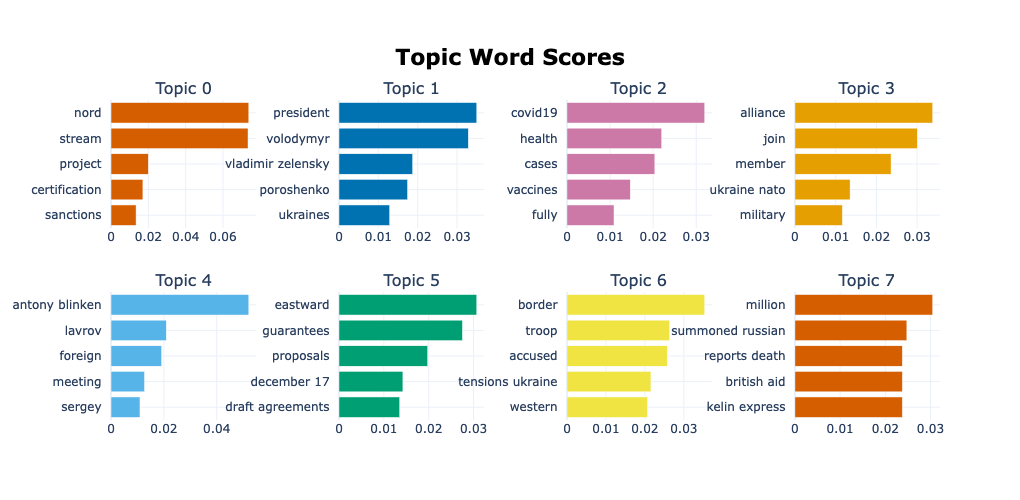

In [89]:
# fig = topic_model.visualize_barchart()
# fig.write_html("path/to/file.html")
topic_model.visualize_barchart()

In [90]:
topic_model.visualize_distribution(probs)

ValueError: This visualization cannot be used if you have set `calculate_probabilities` to False as it uses the topic probabilities of all topics. 

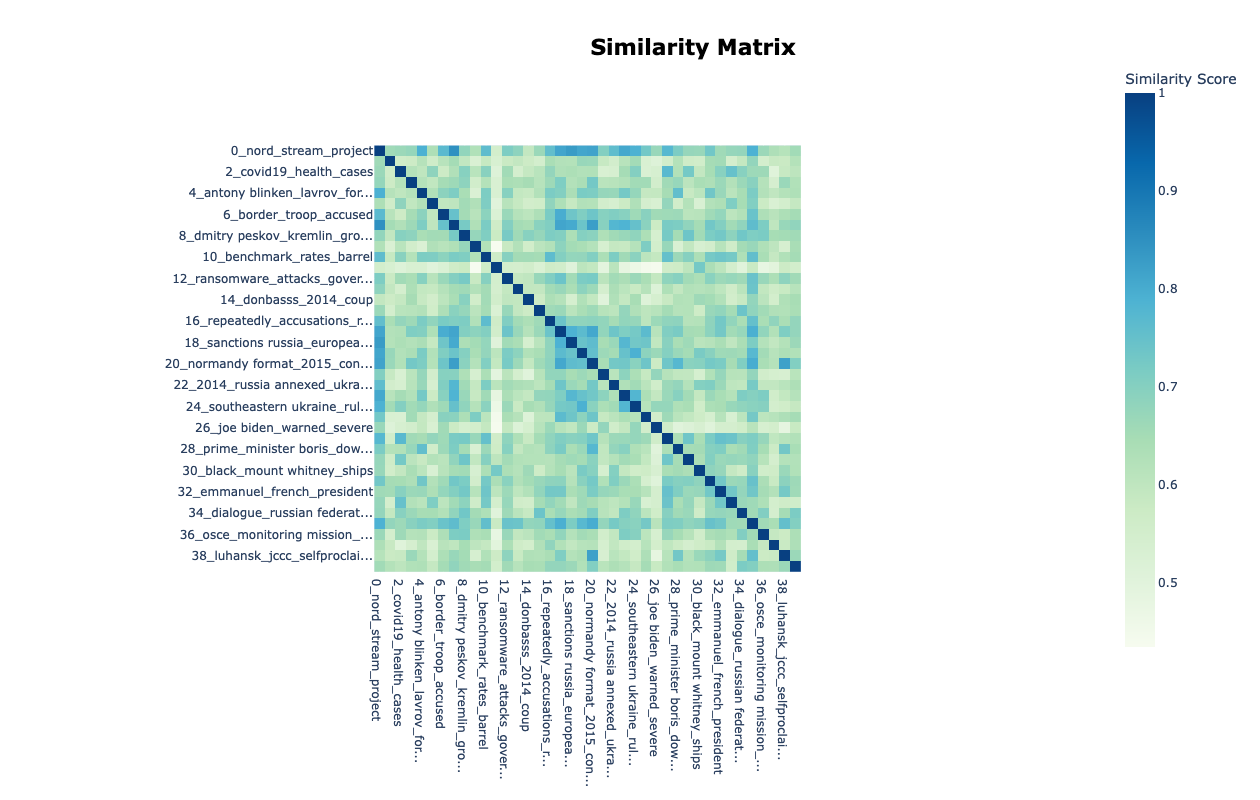

In [91]:
topic_model.visualize_heatmap()

In [93]:
# topic_model.visualize_topics()

In [ ]:
# topics_per_class = topic_model.topics_per_class(docs, topics, classes)
# topic_model.visualize_topics_per_class(topics_per_class)